In [3]:
import numpy as np
import matplotlib.pyplot as plt
import vector
import pandas as pd

In [63]:
# Cabbibo angle, from https://en.wikipedia.org/wiki/Cabibbo%E2%80%93Kobayashi%E2%80%93Maskawa_matrix
theta_c = 13.02 * np.pi/180 # radians
# Tau mass
mtau = 1.77682 # GeV
#
M_V = 0.84 # GeV
# difference between muon and electron magnetic moments (I think, see tau polarization paper)
xi = 3.706
# 
M_A = 1 # GeV
#
F_A_0 = -1.23
# Pion mass
m_pi = 0.139 # GeV

def spin_vector(tau4m, nu4m, nucleon4m, int_type: str):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    # I might also pass this as a parameter. Though probably not, since the model assumes that it is a nucleon, not a nucleus.
    Q2 = -q**2
    # W = (p + q)**2
    x = Q2 / (2*p.dot(q)) # Björken scaling variable

    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    else:
        raise NotImplementedError("Only qel implemented")
    
    F = (
        (2*W1 + mtau**2 / M**2 * W4) * (Etau - ptau * costheta)
        + W2 * (Etau + ptau * costheta)
        + W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
        + mtau**2 / M * W5
    )

    return (
        # sx component, in the tau-nu plane
        -mtau*np.sin(theta)/2 *
        (2*W1 - W2 + Enu / M * W3 - mtau**2/M**2 * W4 + Etau/M * W5)
        / F,
        # sz component
        -1/2 * (
            (2*W1 - mtau**2 / M**2 * W4) * (ptau - Etau * costheta)
            + W2 * (ptau + Etau * costheta)
            + W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
            - mtau**2 / M * W5 * costheta
        ) / F
    )


def w(p, q, M):
    return p.dot(q)/M**2

def G_V_E(q):
    return 1 / (1-q**2/M_V**2)**2

def G_V_M(q):
    return (1+xi) / (1-q**2/M_V**2)**2

def F_V(q, M):
    return (G_V_E(q) - q**2 / (4*M**2) * G_V_M(q)) / (1 - q**2 / (4*M**2))

def F_A(q):
    return F_A_0 / (1 - q**2 / M_A**2)**2

def F_M(q, M):
    return (G_V_M(q) - G_V_M(q)) / (xi * (1 - q**2 / (4*M**2)))

def F_T(q):
    return 0

def F_S(q):
    return 0

def F_p(q, M):
    return 2*M**2 * F_A(q) / (m_pi**2 - q**2)

def Wqel_coefficient(x, Q2, p, q, M):
    # assert np.isclose(x, 1), x  # a delta function here where x must be 1
    return np.cos(theta_c)**2 * 1/w(p, q, M) 

def W1qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        * (F_A(q)**2 + xprime * (F_A(q)**2 + (F_V(q, M) + F_M(q, M))**2))
    )

def omega_2(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return F_V(q, M)**2 + F_A(q)**2 + xprime * (F_M(q, M)**2 + 4*F_T(q)**2)

def W2qel(x, Q2, p, q, M):
    # assert np.isclose(x, 1), x
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        * omega_2(x, Q2, p, q, M)
    )

def W3qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        * -2 * np.real(np.conj(F_A(q)) * (F_V(q, M) + F_M(q, M)))
    )

def W4qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        # omega_4
        * (
            np.real(np.conj(F_V(q, M)) * (F_S(q) - 1/2 * F_M(q, M)) - np.conj(F_A(q)) * (F_T(q) + F_p(q, M)))
            + xprime * (1/2 * (F_M(q, M) - F_S(q))**2 + (F_T(q) + F_p(q, M))**2)
            - 1/4* (1+xprime) * F_M(q, M)**2 + (1+1/2 * xprime) * F_S(q)**2
        )
    )

def W5qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        * (
            2 * np.real(np.conj(F_S(q)) * (F_V(q, M) - xprime*F_M(q, M)) - np.conj(F_T(q)) * (F_A(q) - 2*xprime*F_p(q, M)))
            + omega_2(x, Q2, p, q, M)
        )
    )

# Delta mass
M_delta = 1.232 # GeV
# Delta width assuming dominance of S-waves
Gamma_delta = 0.12 # GeV
# Is 2 if the Delta produced is Delta++ (interaction with p), 
# and 2/3 if the Delta produced is Delta+ (interaction with n). 
# Maybe take average, since there are equally many n and p in Oxygen?
kappa = 2

# def W1res(x, Q2, p, q, M):
#     return (
#         kappa * np.cos(theta_c)**2 * M * M_delta * 
#         eta_delta_bw(W)**2 * 
#         sum(
#             V_1(x, Q2, j, k) * C_V(x, Q2, j) * C_V(x, Q2, k) 
#             + A_1(x, Q2, j, k) * C_A(x, Q2, j) * C_A(x, Q2, k) 
#             for j, k in itertools.product(range(3, 7), repeat=2)
#         )
#     )

In [64]:
particle_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_particles.csv")
event_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_event_info.csv")

qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]

In [83]:
taus = qel_particles[qel_particles["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])
(tau_angles < 0.01).sum()
zero_angle_tau = taus.values[np.argmin(tau_angles)]

In [84]:
nucleon4m = vector.obj(**{"E": 1, "px": 0, "py": 0, "pz": 0})
nu4m = vector.obj(**{"E": 10, "px": 0, "py": 0, "pz": 10})
tau4m = vector.obj(**{"E": zero_angle_tau[2], "px": zero_angle_tau[3], "py": zero_angle_tau[4], "pz": zero_angle_tau[5]})

In [87]:
s = np.array(spin_vector(tau4m, nu4m, nucleon4m, "qel"))
# The polarization (second term) should be slightly less than 1
# See center left panel, figure 6 in tau polarization paper
s, np.linalg.norm(s)*2 

(array([ 3.41926028e-05, -3.74228882e-01]), 0.7484577665708191)

(-10.0, 10.0)

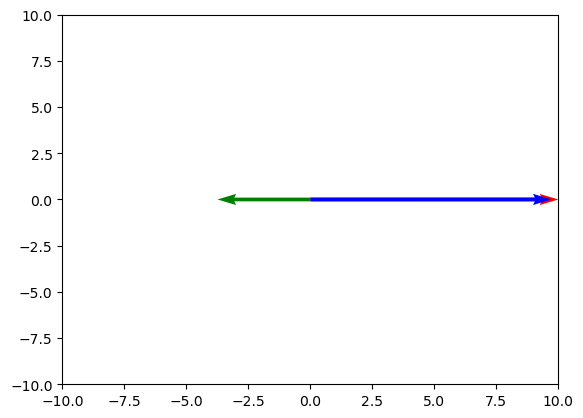

In [86]:
# Plot the two arrows in the pz-pt plave
plt.quiver(0, 0, nu4m.pz, nu4m.pt, angles='xy', scale_units='xy', scale=1, color="r")
plt.quiver(0, 0, tau4m.pz, tau4m.pt, angles='xy', scale_units='xy', scale=1, color="b")
plt.quiver(0, 0, s[1], s[0], angles='xy', scale_units='xy', scale=0.1, color="g")
plt.xlim(-10, 10)
plt.ylim(-10, 10)